In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import functions
%matplotlib inline


# General information:
The midbootcamp project: Can we predict cancer using gene expression profile?

# To approach this objective:
1. select gene expression datasets for different types of cancers
2. Data checking, cleaning, transform if needed
3. Identify genes that are differentially expressed (called DEGs) in cancer samples vs normal samples. Using two samples t-test at p_sig = 0.05
4. Check and excluding genes that are highly correlated among the identified DEGs subset with a threshold for exluding at 0.95
5. Split and train model on working datasets:
    * using transformed data (using quantile transformation) vs non-transformed data 
6. Validation:
   * on the whole (train + test) dataset
   * using a new dataset of the same cancer type
   * calculation all validation metrics: precision, accuracy, recel, F1, cohen_kappa_score
     
# From the GEO database, we selected 3 expression profiling datasets for 3 types of cancers: prostate, breats, leukemia
1. link for download gene expression dataset: https://sbcb.inf.ufrgs.br/cumida
2. every dataset has it unique identifier as accession number GSE
3. For breast cancer dataset, accession number is GSE22820
    Description: it is expression profiling by array, generated from 176 primary breast cancer patients and 10 normal breast samples.
NOTE: however, when loading this dataset, there are only 129 primary breast cancer patients and 10 normal breast samples.
This should not affect the analysis.
4. since these datasets are repositories from different research groups to NCBI database (GEO), the format and setup is already standardized. Therefore, most likely, it will not require a cleaning process.
     

In [6]:
# load the gene expression dataset

path = '/Users/minhnguyen/IronHack2023-2024/Bootcamp/Labs/5_Mid_bootcamp_project_venv/data/Breast_GSE22820.csv'
df = pd.read_csv(path)
df.head(10)

,samples,type,NM_004900,AA085955,NM_014616,AK092846,NM_001539,THC2450799,NM_006709,NM_000978,...,AF117899,A_24_P287526,THC2349421,THC2272949,NM_138411,THC2350949,CR600872,NM_016058,AF520801,NM_203414
0,GSM563920_1,primary_breast_cancer,7.642101,4.803022,7.939666,5.790127,12.162603,5.378933,9.117912,13.907735,...,5.420074,5.535341,7.087367,5.940366,9.781396,4.740855,6.037292,8.960350,4.578823,8.486862
1,GSM563922_3,primary_breast_cancer,4.758954,5.150573,6.568998,5.352497,12.067264,4.606413,7.502331,14.625330,...,5.303676,5.303676,6.215967,4.731728,9.725169,5.381360,6.315188,9.064591,4.453024,9.982885
2,GSM563923_4,primary_breast_cancer,6.423254,4.408955,8.668739,4.979653,11.704731,6.466557,7.671957,13.580480,...,6.002756,6.023807,5.409657,5.036619,8.164628,5.230133,5.604062,10.090701,4.354638,8.361384
3,GSM563924_5,primary_breast_cancer,8.385947,4.454648,8.721586,5.121018,11.228727,5.390309,7.610587,13.933777,...,5.162009,5.176968,6.425804,4.810718,8.025828,4.511641,5.826439,9.580325,4.352350,7.998807
4,GSM563925_6,primary_breast_cancer,7.630389,4.598275,8.387313,5.221780,11.863483,4.501516,7.184051,14.535956,...,5.398244,5.345064,6.235113,4.618548,9.012896,6.544705,5.465001,10.584008,4.356300,7.862625
5,GSM563926_7,primary_breast_cancer,8.920266,4.713536,7.220090,6.337220,12.006183,7.744621,6.692041,14.449527,...,5.343288,5.343288,6.228258,4.628901,9.431941,8.218623,6.033377,10.149946,4.368847,7.726911
6,GSM563927_8,primary_breast_cancer,8.381502,4.788302,7.502661,5.438383,12.215057,5.160352,7.126575,14.226132,...,5.516072,5.378623,5.113644,5.062141,9.019891,4.959735,5.774270,10.016995,4.456662,9.798303
7,GSM563928_9,primary_breast_cancer,9.209772,4.689143,8.787514,5.216824,13.070204,4.458963,7.800924,13.902623,...,5.349400,5.537738,5.861783,4.838839,7.656276,5.583532,5.926412,9.482813,4.443359,8.010459
8,GSM563929_10,primary_breast_cancer,8.174604,4.922422,8.908414,6.405099,11.816925,4.524714,8.442629,14.248786,...,5.400082,5.376378,6.128218,4.775396,9.036853,5.443457,4.451945,9.436089,4.399745,10.402742
9,GSM563930_11,primary_breast_cancer,8.582873,5.439284,8.463425,5.439284,12.398760,5.104956,7.765574,13.237828,...,5.680828,5.825395,5.525873,4.476015,8.602001,4.941818,4.941818,10.005473,4.413101,8.013785


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Columns: 33581 entries, samples to NM_203414
dtypes: float64(33579), object(2)
memory usage: 35.6+ MB


In [8]:
# change data format using melt, so that can be used in boxplot

melted_data = df.melt(id_vars=['samples', 'type'], var_name='gene', value_name='expression')
melted_data
    

,samples,type,gene,expression
0,GSM563920_1,primary_breast_cancer,NM_004900,7.642101
1,GSM563922_3,primary_breast_cancer,NM_004900,4.758954
2,GSM563923_4,primary_breast_cancer,NM_004900,6.423254
3,GSM563924_5,primary_breast_cancer,NM_004900,8.385947
4,GSM563925_6,primary_breast_cancer,NM_004900,7.630389
...,...,...,...,...
4667476,GSM564101_182,normal,NM_203414,9.385845
4667477,GSM564102_183,normal,NM_203414,9.461447
4667478,GSM564103_184,normal,NM_203414,8.371678
4667479,GSM564104_185,normal,NM_203414,9.250493


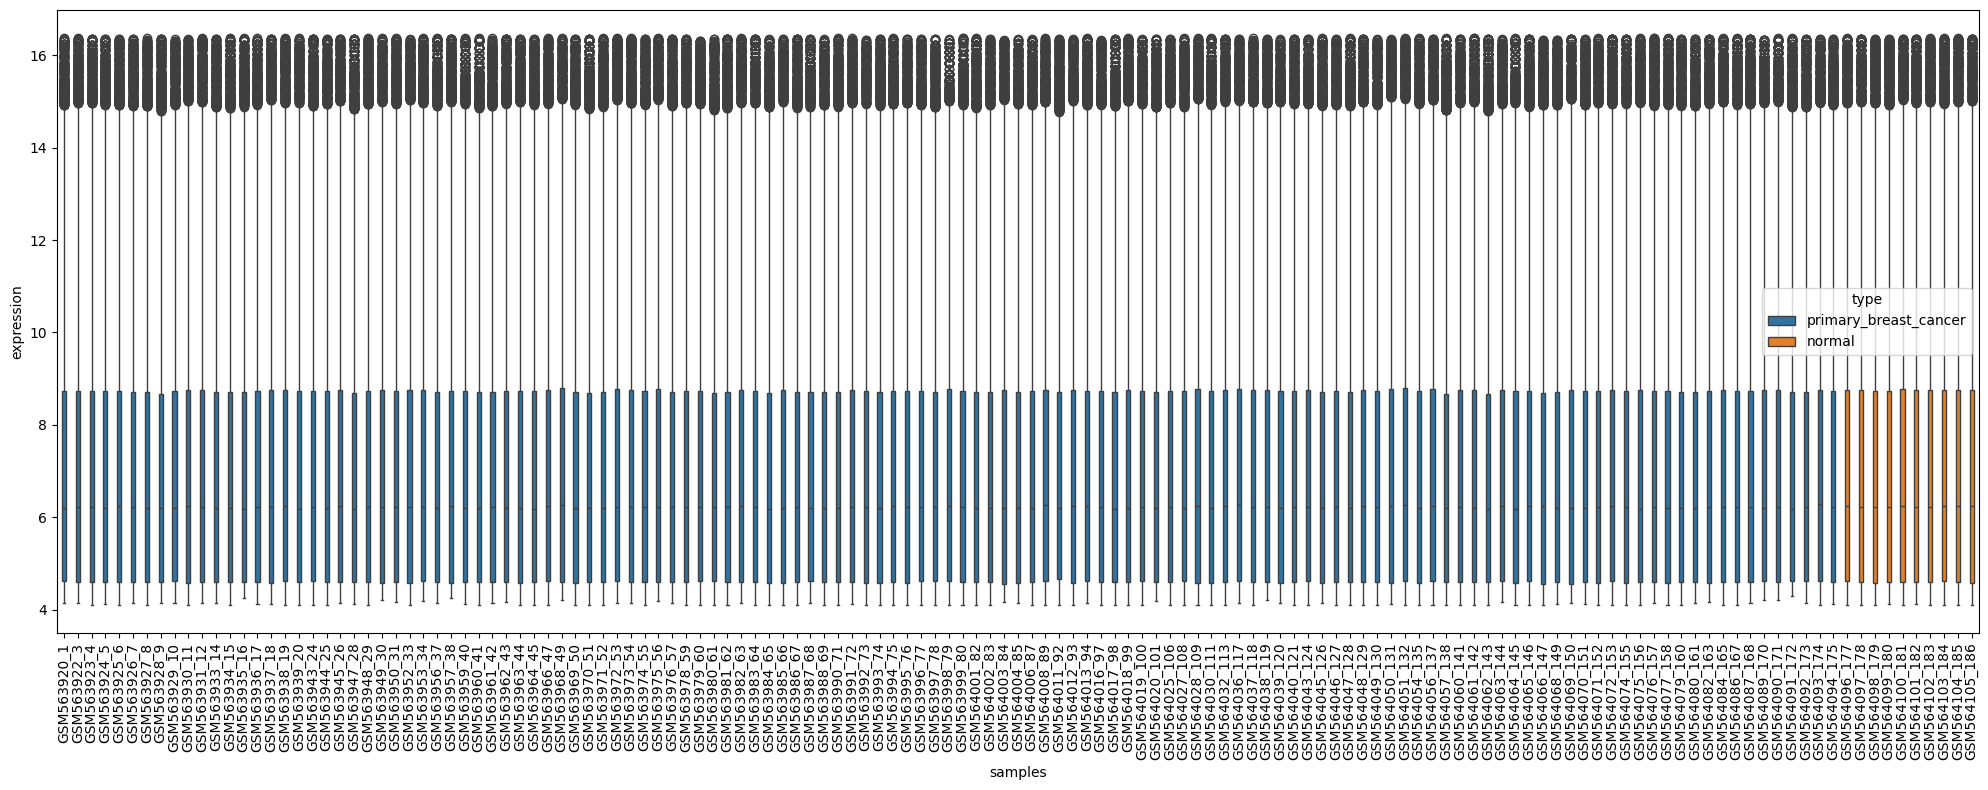

In [9]:

# Create a boxplot with melted data

plt.figure(figsize=(20, 8))  # Adjust figure size if needed
sns.boxplot(x='samples', y='expression', hue = 'type',  data=melted_data, width = 0.3)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


# Testing 1: apply log transformation on original expression value

In [43]:
# apply log transformation to data
melted_data_log = melted_data.copy()
melted_data_log['expression'] = melted_data_log['expression'].apply(lambda x: np.log10(x))
melted_data_log.head()

,samples,type,gene,expression
0,GSM563920_1,primary_breast_cancer,NM_004900,0.883213
1,GSM563922_3,primary_breast_cancer,NM_004900,0.677512
2,GSM563923_4,primary_breast_cancer,NM_004900,0.807755
3,GSM563924_5,primary_breast_cancer,NM_004900,0.923552
4,GSM563925_6,primary_breast_cancer,NM_004900,0.882547


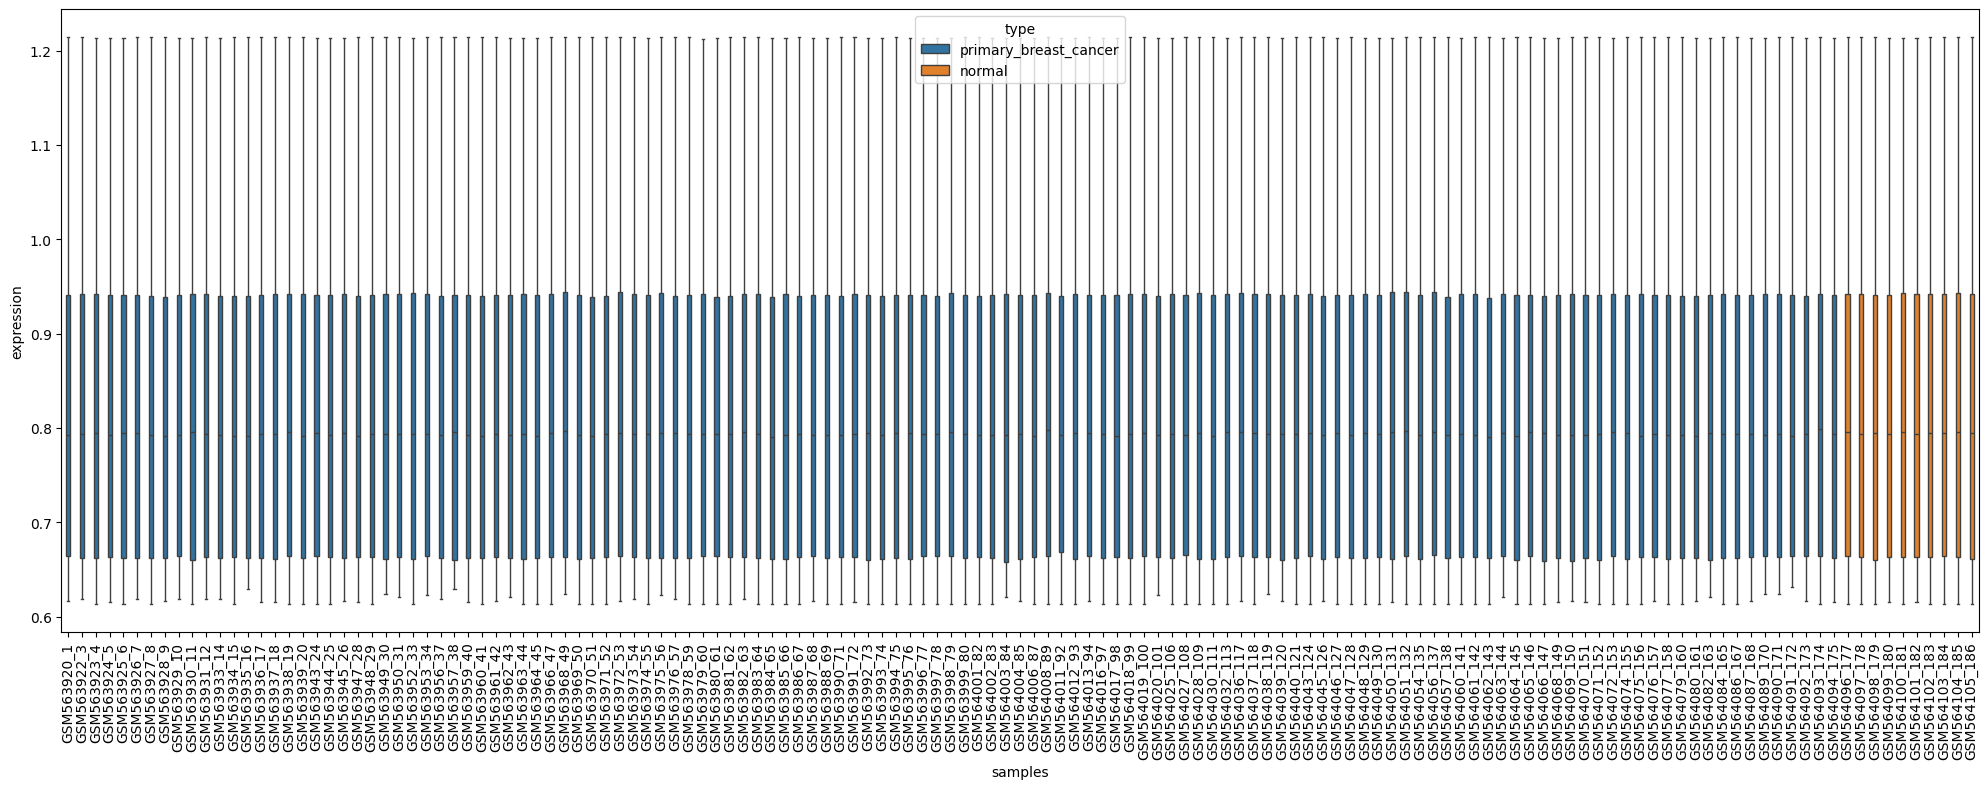

In [44]:
# plot log transformed data on boxplot

plt.figure(figsize=(20, 8))  # Adjust figure size if needed
sns.boxplot(x='samples', y='expression', hue = 'type',  data=melted_data_log, width = 0.3)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

In [39]:
#df_genes = df.drop(['samples', 'type'], axis = 1)
df_transformed = df.copy()

# apply quantile transformation to data
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer (output_distribution ='normal')
qt.fit(df[df.columns[2:]])
df_transformed[df.columns[2:]] = qt.transform(df[df.columns[2:]])
#melted_data_log['expression'] = melted_data_log['expression'].apply(lambda x: np.log10(x))
#melted_data_log.head()

/Users/minhnguyen/IronHack2023-2024/Bootcamp/Labs/5_Mid_bootcamp_project_venv/venv/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (139). n_quantiles is set to n_samples.
  warnings.warn(


In [42]:
melted_df_transformed = df_transformed.melt(id_vars=['samples', 'type'], var_name='gene', value_name='expression')
melted_df_transformed

,samples,type,gene,expression
0,GSM563920_1,primary_breast_cancer,NM_004900,0.000000
1,GSM563922_3,primary_breast_cancer,NM_004900,-5.199338
2,GSM563923_4,primary_breast_cancer,NM_004900,-0.910955
3,GSM563924_5,primary_breast_cancer,NM_004900,0.732656
4,GSM563925_6,primary_breast_cancer,NM_004900,-0.018165
...,...,...,...,...
4667476,GSM564101_182,normal,NM_203414,0.511936
4667477,GSM564102_183,normal,NM_203414,0.596675
4667478,GSM564103_184,normal,NM_203414,-0.275921
4667479,GSM564104_185,normal,NM_203414,0.371661


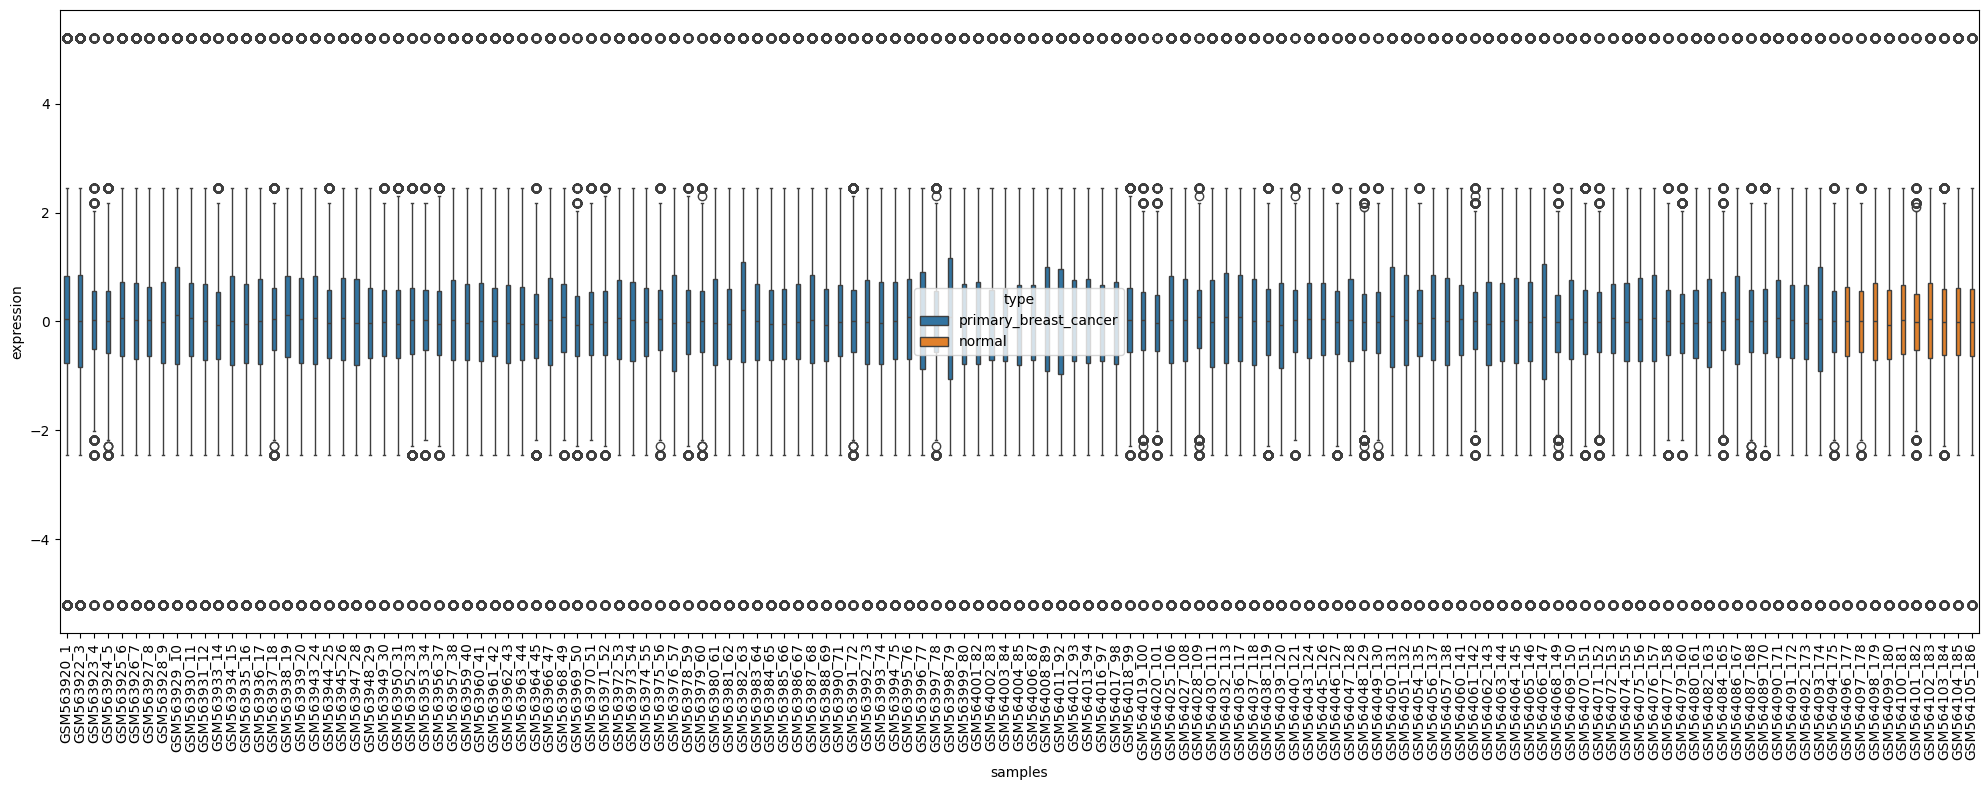

In [41]:
# plot log transformed data on boxplot

plt.figure(figsize=(20, 8))  # Adjust figure size if needed
sns.boxplot(x='samples', y='expression', hue = 'type',  data=melted_df_transformed, width = 0.3)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

In [4]:
df.iloc[0,3:].max()

16.3663369766825

normal = df[df['type'] == 'normal']
df.groupby(df['type']).mean()

In [13]:
import scipy.stats as st

In [14]:
df_cancer = df[df['type'] == "primary_breast_cancer"]
df_normal = df[df['type'] == "normal"]
df_cancer.head()
display(df_cancer.shape)
df_normal.head()
display(df_normal.shape)

(129, 33581)

(10, 33581)

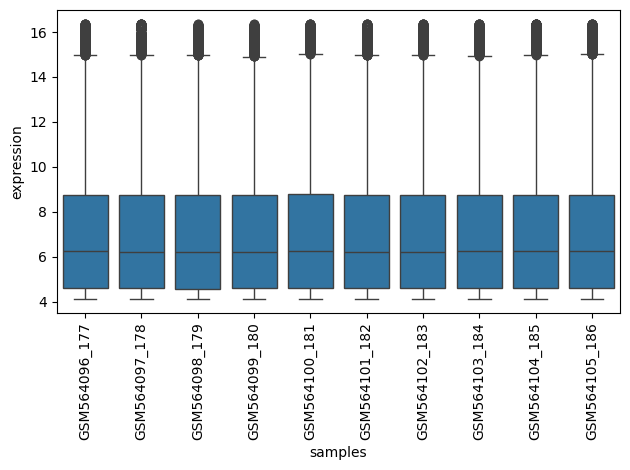

In [17]:
df_normal_melted = df_normal.melt(id_vars=['samples', 'type'], var_name='gene', value_name='expression')
sns.boxplot(df_normal_melted, x='samples', y='expression')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

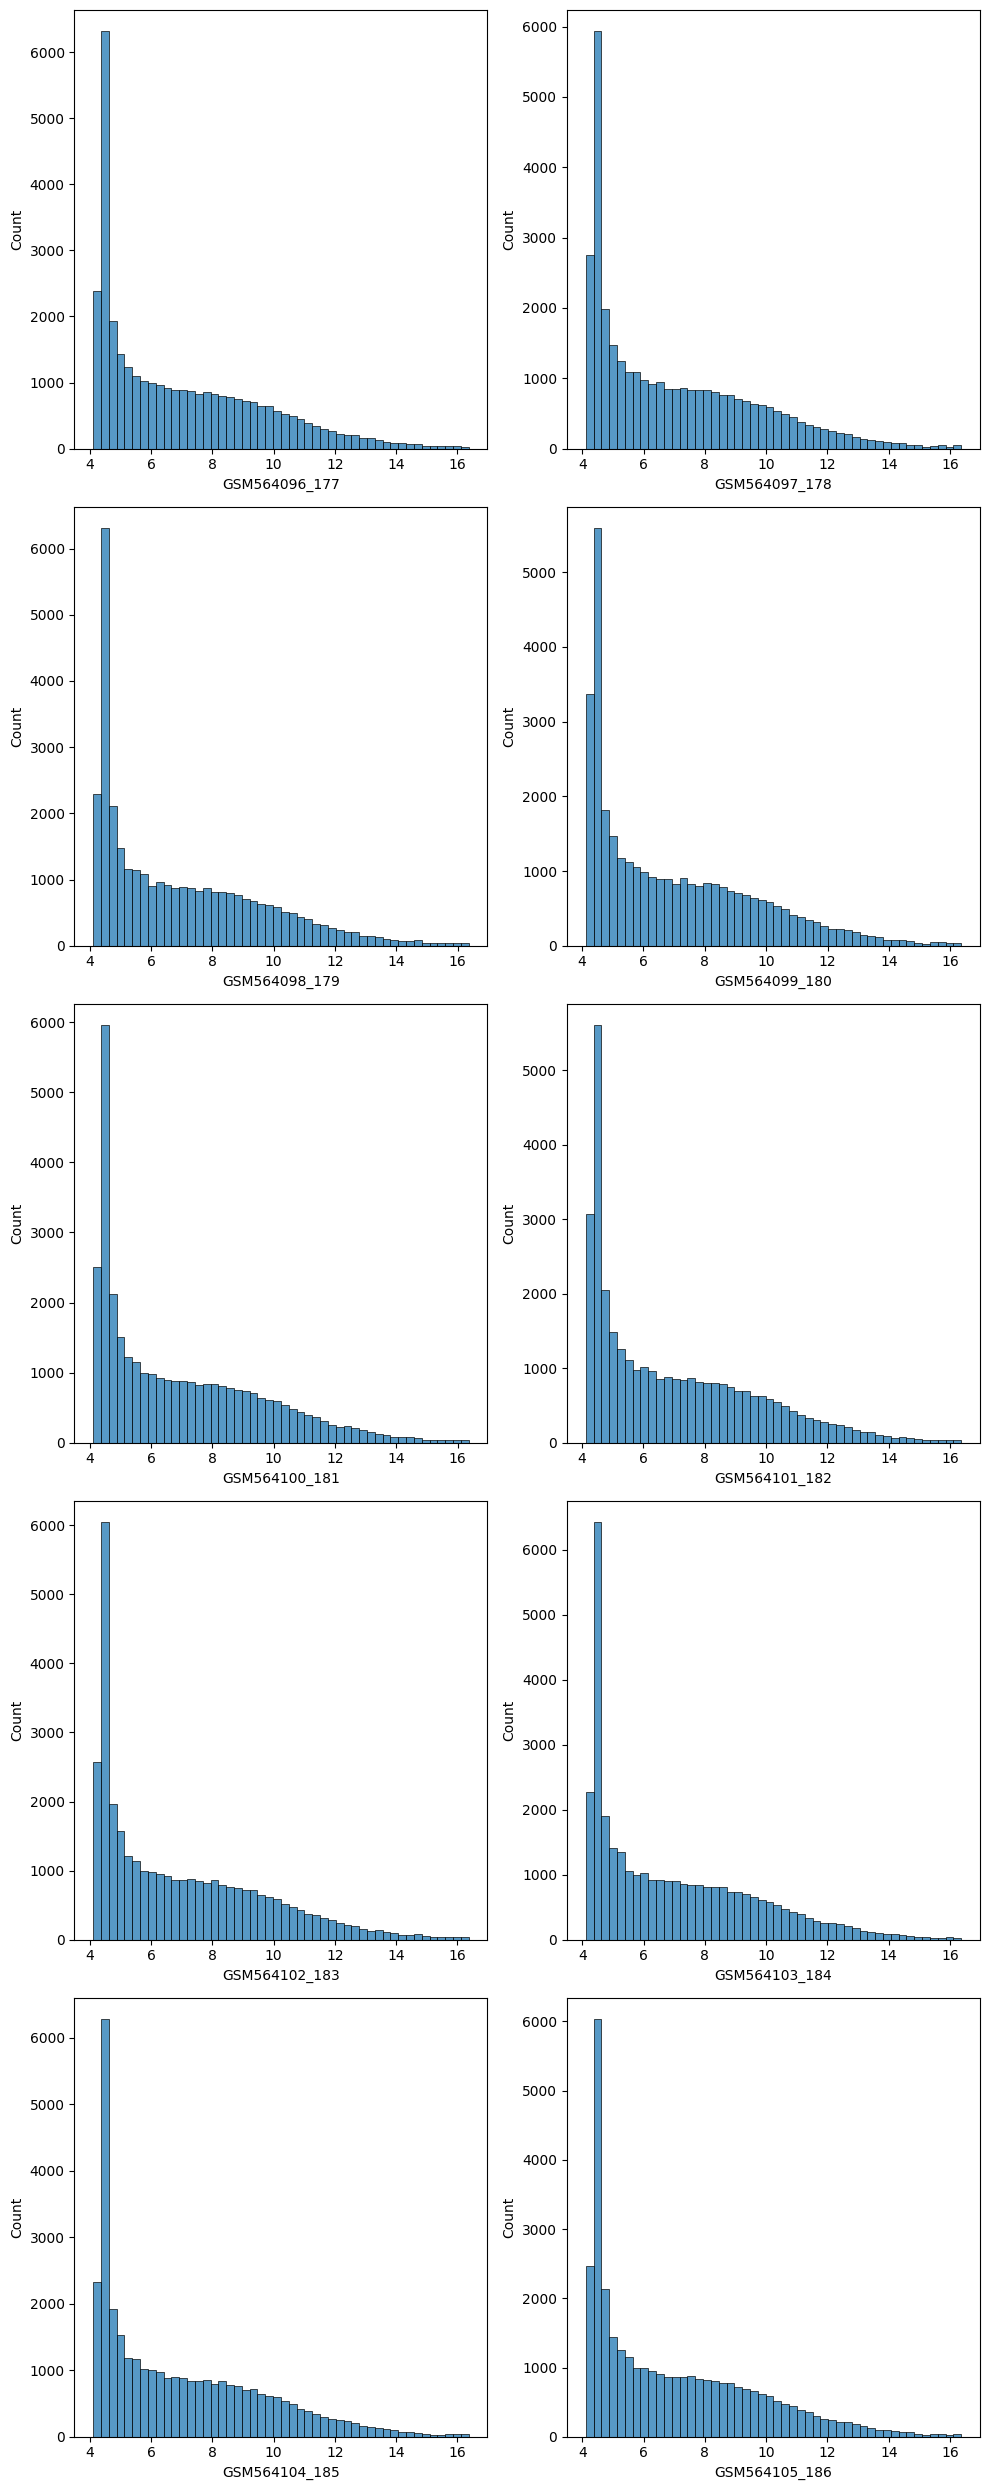

In [15]:
fig, ax = plt.subplots(5,2, figsize = (10,5 * 5))
row_index = 0
col_index = 0
for i in range(10):
    sns.histplot(df_normal.iloc[i,3:], ax = ax[row_index, col_index])
    ax[row_index, col_index].set_xlabel(df_normal.iloc[i,0])
    col_index +=1
    if col_index >1:
        col_index = 0
        row_index +=1
plt.tight_layout()
plt.show()


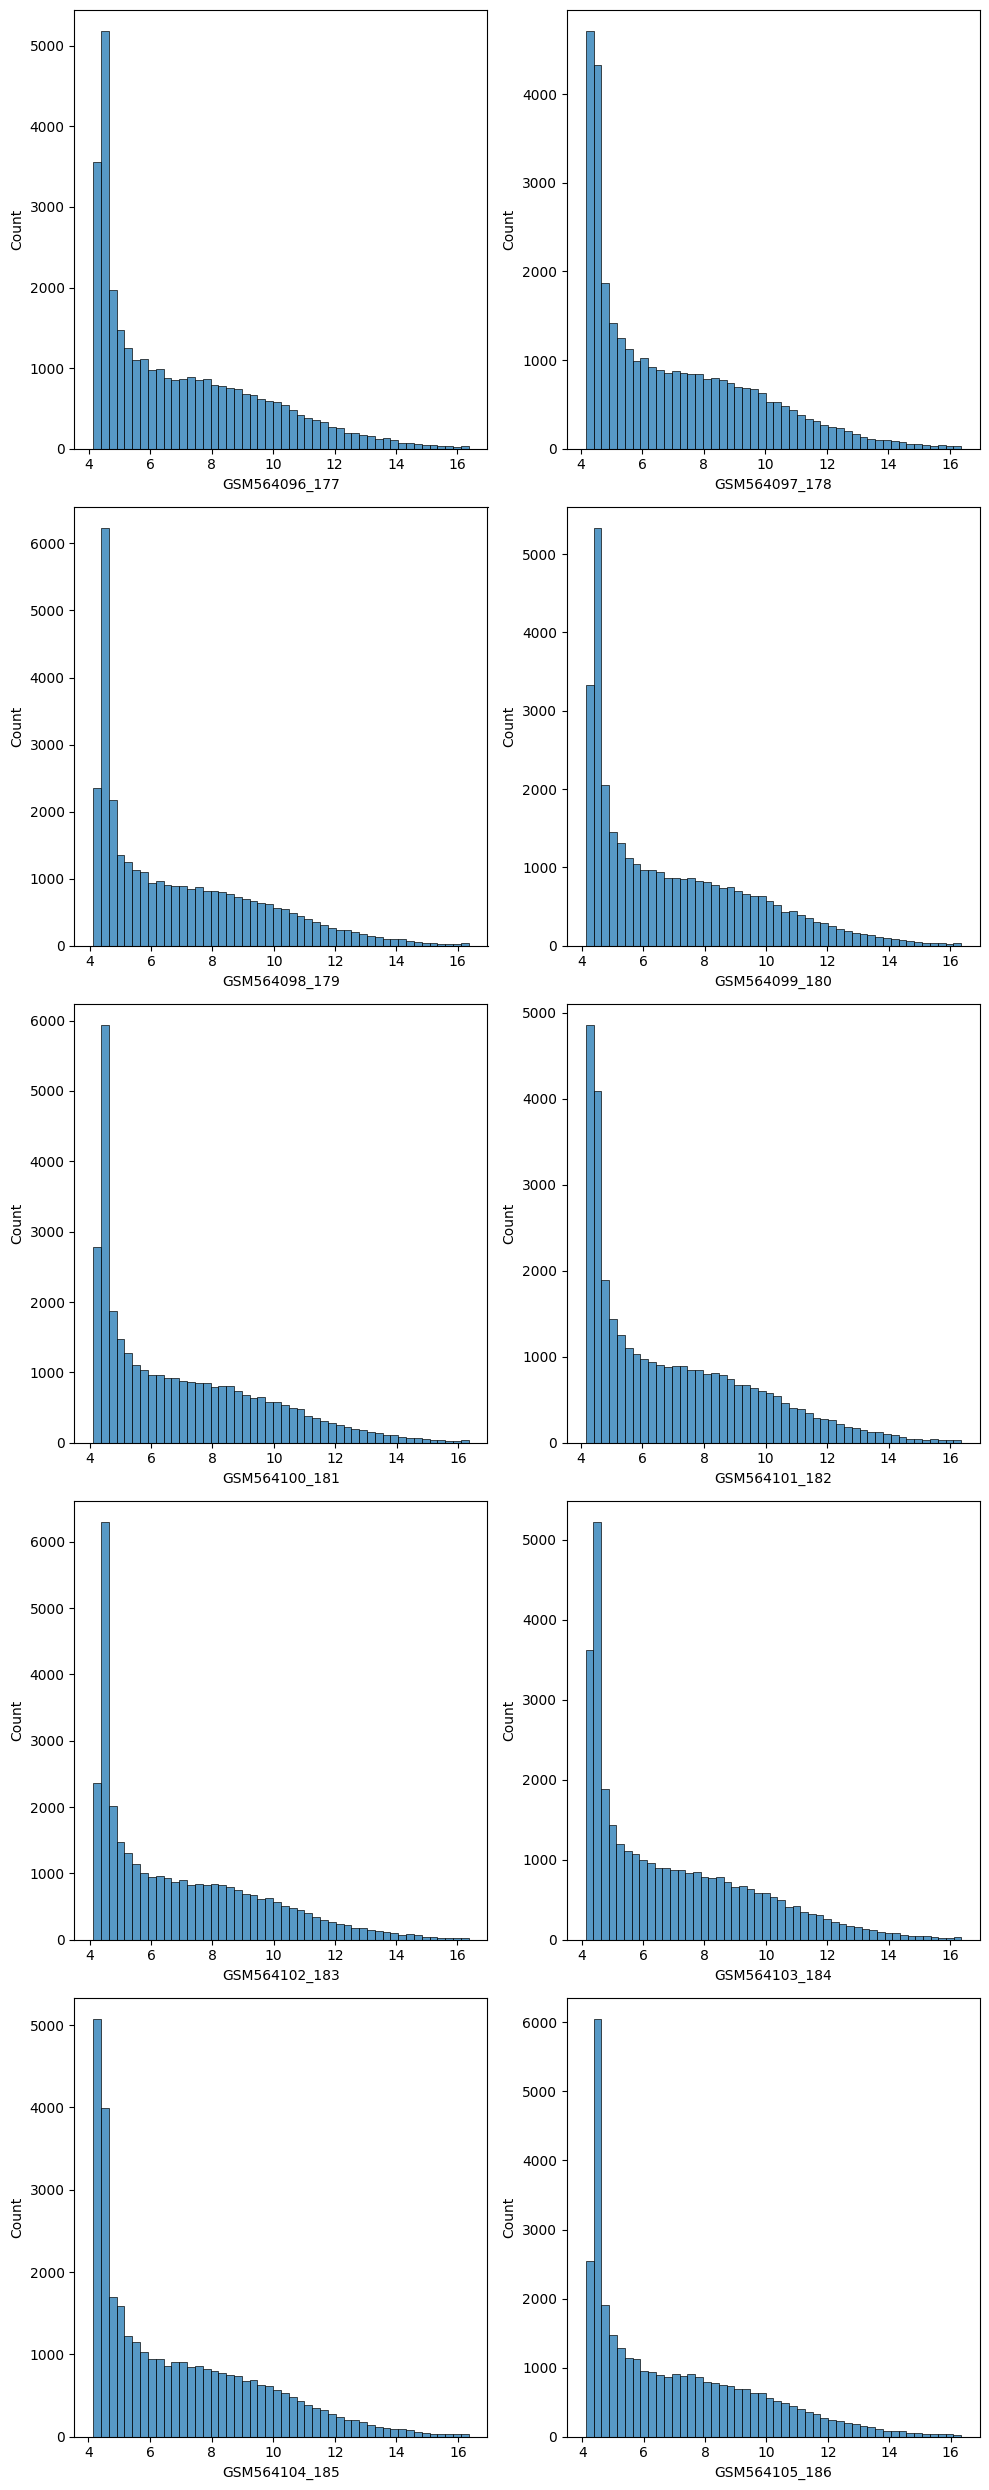

In [18]:
fig, ax = plt.subplots(5,2, figsize = (10,5 * 5))
row_index = 0
col_index = 0
for i in range(10):
    sns.histplot(df_cancer.iloc[i,3:], ax = ax[row_index, col_index])
    ax[row_index, col_index].set_xlabel(df_normal.iloc[i,0])
    col_index +=1
    if col_index >1:
        col_index = 0
        row_index +=1
plt.tight_layout()
plt.show()
    

In [19]:
df_cancer.columns[2:]

Index(['NM_004900', 'AA085955', 'NM_014616', 'AK092846', 'NM_001539',
       'THC2450799', 'NM_006709', 'NM_000978', 'T12590', 'A_24_P704878',
       ...
       'AF117899', 'A_24_P287526', 'THC2349421', 'THC2272949', 'NM_138411',
       'THC2350949', 'CR600872', 'NM_016058', 'AF520801', 'NM_203414'],
      dtype='object', length=33579)

In [20]:
p_sig = 0.05
for col in df_cancer.columns[2:5]:
    t, pvalue= st.ttest_ind(df_cancer[col],df_normal[col], equal_var = False, alternative = 'two-sided')
    print(t, pvalue)
    if pvalue < p_sig:
        print("df_cancer_mean is not equal df_normal_mean")
    else:
        print("there is no difference between 2 populations")

5.443845901006186 4.3210001085227666e-05
df_cancer_mean is not equal df_normal_mean
1.9051192289195709 0.0770817609468967
there is no difference between 2 populations
-4.142338550437853 0.00035764289488124715
df_cancer_mean is not equal df_normal_mean


In [21]:
p_sig = 0.05
differential_expressed_genes = []
for col in df_cancer.columns[2:]:
    t, pvalue= st.ttest_ind(df_cancer[col],df_normal[col], equal_var = False, alternative = 'two-sided')
    if pvalue < p_sig:
        differential_expressed_genes.append(str(col))
differential_expressed_genes 


['NM_004900',
 'NM_014616',
 'AK092846',
 'NM_001539',
 'THC2450799',
 'NM_000978',
 'T12590',
 'NM_001017',
 'NM_000311',
 'AK091028',
 'AK057596',
 'AY358648',
 'NM_032445',
 'NM_004886',
 'NM_014478',
 'NM_016506',
 'NM_002332',
 'NM_000368',
 'NM_000677',
 'NM_005895',
 'AA071045',
 'NM_031462',
 'AI287491',
 'NM_080655',
 'NM_003131',
 'AK094799',
 'NM_020235',
 'NM_003045',
 'A_24_P530900',
 'NM_145690',
 'NM_004431',
 'NM_014573',
 'NM_003011',
 'AA512897',
 'NM_000619',
 'CN479126',
 'A_32_P156549',
 'NM_152703',
 'AT_ssH_TR_5',
 'NM_032515',
 'BG167701',
 'NM_001029863',
 'NM_001014445',
 'NM_001033',
 'AT_ssH_PC_3',
 'NM_005339',
 'NM_024709',
 'A_24_P50489',
 'NM_144583',
 'AK022865',
 'NM_006177',
 'NM_173827',
 'NM_001018036',
 'E1A_r60_3',
 'NM_004004',
 'AF035020',
 'THC2438309',
 'A_32_P10665',
 'NM_022830',
 'NM_000049',
 'NM_005603',
 'NM_194259',
 'NM_145028',
 'NM_000979',
 'NM_001806',
 'NM_003680',
 'NM_152531',
 'NM_000024',
 'NM_019034',
 'NM_004779',
 'THC24283

In [22]:
len(differential_expressed_genes)

19490

In [14]:
df['type']

0      primary_breast_cancer
1      primary_breast_cancer
2      primary_breast_cancer
3      primary_breast_cancer
4      primary_breast_cancer
               ...          
134                   normal
135                   normal
136                   normal
137                   normal
138                   normal
Name: type, Length: 139, dtype: object

In [23]:
deg_df = df[['samples', 'type'] + differential_expressed_genes]
deg_df

,samples,type,NM_004900,NM_014616,AK092846,NM_001539,THC2450799,NM_000978,T12590,NM_001017,...,NM_024887,NM_021168,NM_005086,AK096148,BX414807,AL832183,AF117899,THC2349421,THC2272949,NM_203414
0,GSM563920_1,primary_breast_cancer,7.642101,7.939666,5.790127,12.162603,5.378933,13.907735,4.918658,13.533483,...,6.740345,9.571465,8.155324,6.037292,6.186230,11.113530,5.420074,7.087367,5.940366,8.486862
1,GSM563922_3,primary_breast_cancer,4.758954,6.568998,5.352497,12.067264,4.606413,14.625330,4.883529,14.487884,...,6.102728,9.242387,8.232784,6.107088,4.795892,11.119205,5.303676,6.215967,4.731728,9.982885
2,GSM563923_4,primary_breast_cancer,6.423254,8.668739,4.979653,11.704731,6.466557,13.580480,4.551058,14.220230,...,6.786114,8.892251,10.527390,5.308463,5.896109,11.935986,6.002756,5.409657,5.036619,8.361384
3,GSM563924_5,primary_breast_cancer,8.385947,8.721586,5.121018,11.228727,5.390309,13.933777,4.744501,13.557500,...,6.671023,7.619908,9.685097,5.841109,4.999826,12.159585,5.162009,6.425804,4.810718,7.998807
4,GSM563925_6,primary_breast_cancer,7.630389,8.387313,5.221780,11.863483,4.501516,14.535956,5.137961,14.154754,...,6.154131,7.763267,9.647408,5.701639,5.788941,11.530416,5.398244,6.235113,4.618548,7.862625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,GSM564101_182,normal,7.389932,8.486529,5.032610,11.364942,5.981754,14.159944,4.621662,14.072302,...,6.896548,7.968914,10.259590,5.531316,4.936424,12.053818,5.602249,5.079415,4.970296,9.385845
135,GSM564102_183,normal,6.396778,9.453966,5.234155,11.380491,7.349289,14.958784,4.663486,14.368535,...,6.640277,7.756662,11.401666,6.076080,5.022355,13.644152,5.724029,5.910954,5.183218,9.461447
136,GSM564103_184,normal,6.465171,9.053491,4.761524,11.441499,7.498902,14.058164,4.616924,13.954264,...,7.551332,8.055169,10.624326,5.401489,5.735350,12.886619,6.335111,5.301914,5.177253,8.371678
137,GSM564104_185,normal,5.728902,9.008859,4.827861,11.527671,6.404394,14.198314,4.608138,13.964812,...,7.160949,7.864288,10.907326,5.034105,5.199878,11.960737,6.067234,5.639116,4.931638,9.250493


In [24]:
df[differential_expressed_genes]

,NM_004900,NM_014616,AK092846,NM_001539,THC2450799,NM_000978,T12590,NM_001017,NM_000311,AK091028,...,NM_024887,NM_021168,NM_005086,AK096148,BX414807,AL832183,AF117899,THC2349421,THC2272949,NM_203414
0,7.642101,7.939666,5.790127,12.162603,5.378933,13.907735,4.918658,13.533483,9.682090,6.335589,...,6.740345,9.571465,8.155324,6.037292,6.186230,11.113530,5.420074,7.087367,5.940366,8.486862
1,4.758954,6.568998,5.352497,12.067264,4.606413,14.625330,4.883529,14.487884,9.503342,6.300958,...,6.102728,9.242387,8.232784,6.107088,4.795892,11.119205,5.303676,6.215967,4.731728,9.982885
2,6.423254,8.668739,4.979653,11.704731,6.466557,13.580480,4.551058,14.220230,10.004852,8.138073,...,6.786114,8.892251,10.527390,5.308463,5.896109,11.935986,6.002756,5.409657,5.036619,8.361384
3,8.385947,8.721586,5.121018,11.228727,5.390309,13.933777,4.744501,13.557500,10.647643,8.604634,...,6.671023,7.619908,9.685097,5.841109,4.999826,12.159585,5.162009,6.425804,4.810718,7.998807
4,7.630389,8.387313,5.221780,11.863483,4.501516,14.535956,5.137961,14.154754,8.894883,7.544793,...,6.154131,7.763267,9.647408,5.701639,5.788941,11.530416,5.398244,6.235113,4.618548,7.862625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,7.389932,8.486529,5.032610,11.364942,5.981754,14.159944,4.621662,14.072302,11.157754,7.680679,...,6.896548,7.968914,10.259590,5.531316,4.936424,12.053818,5.602249,5.079415,4.970296,9.385845
135,6.396778,9.453966,5.234155,11.380491,7.349289,14.958784,4.663486,14.368535,12.188055,8.142205,...,6.640277,7.756662,11.401666,6.076080,5.022355,13.644152,5.724029,5.910954,5.183218,9.461447
136,6.465171,9.053491,4.761524,11.441499,7.498902,14.058164,4.616924,13.954264,11.078226,7.892066,...,7.551332,8.055169,10.624326,5.401489,5.735350,12.886619,6.335111,5.301914,5.177253,8.371678
137,5.728902,9.008859,4.827861,11.527671,6.404394,14.198314,4.608138,13.964812,11.721519,8.338777,...,7.160949,7.864288,10.907326,5.034105,5.199878,11.960737,6.067234,5.639116,4.931638,9.250493


In [17]:
corr_matrix_df = df[differential_expressed_genes].corr()

In [18]:
corr_matrix_df

,NM_004900,NM_014616,AK092846,NM_001539,THC2450799,NM_000978,T12590,NM_001017,NM_000311,AK091028,...,NM_024887,NM_021168,NM_005086,AK096148,BX414807,AL832183,AF117899,THC2349421,THC2272949,NM_203414
NM_004900,1.000000,0.093490,0.079161,0.320529,-0.226062,-0.278840,-0.006746,-0.157603,0.168783,-0.350136,...,-0.090765,-0.227356,-0.097135,0.330230,0.066793,-0.028143,0.072722,-0.142180,0.303745,-0.063048
NM_014616,0.093490,1.000000,-0.176092,0.116271,-0.161422,-0.141226,-0.234667,-0.027101,0.315804,-0.073984,...,0.189011,-0.193066,0.321814,0.171925,-0.084393,0.179174,0.061815,-0.096108,0.226750,0.016664
AK092846,0.079161,-0.176092,1.000000,0.117795,0.081581,0.108563,0.091432,-0.069342,-0.073314,-0.094043,...,-0.256239,0.117177,-0.215860,0.118203,0.107614,-0.099789,-0.153021,0.061695,0.014345,0.117928
NM_001539,0.320529,0.116271,0.117795,1.000000,-0.286041,-0.121506,-0.137278,-0.069397,0.276132,-0.279253,...,-0.004737,-0.142349,-0.125134,0.391127,0.023855,-0.207753,-0.263083,0.046106,0.061100,-0.089938
THC2450799,-0.226062,-0.161422,0.081581,-0.286041,1.000000,0.182242,0.028506,0.074482,-0.063072,0.240480,...,-0.054184,0.097587,0.203347,-0.229731,-0.002640,0.025579,0.258495,0.005723,-0.173204,0.022740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL832183,-0.028143,0.179174,-0.099789,-0.207753,0.025579,0.013993,-0.209962,0.151770,0.209756,0.123357,...,0.172998,-0.072589,0.327738,0.006327,-0.107510,1.000000,0.145286,-0.086830,0.152936,0.090072
AF117899,0.072722,0.061815,-0.153021,-0.263083,0.258495,-0.267938,0.047514,-0.211483,-0.189461,0.114145,...,0.380523,0.204251,0.014489,-0.170457,0.009570,0.145286,1.000000,-0.018607,0.099431,-0.055570
THC2349421,-0.142180,-0.096108,0.061695,0.046106,0.005723,-0.120981,-0.284038,-0.225992,-0.284762,-0.205667,...,0.214144,0.353969,-0.379031,0.196262,-0.040925,-0.086830,-0.018607,1.000000,0.025054,-0.035784
THC2272949,0.303745,0.226750,0.014345,0.061100,-0.173204,-0.069557,-0.218305,0.025837,0.224899,-0.435833,...,-0.016746,-0.279620,-0.090060,0.202647,0.324845,0.152936,0.099431,0.025054,1.000000,0.090015


In [101]:
pd.DataFrame(corr_matrix_df.iterrows())
corr_matrix_df.row.items()

AttributeError: 'DataFrame' object has no attribute 'row'

In [ ]:
def find_correlated_genes_optimized(r_values, threshold=0.95):
    correlated_genes_list = []

    # Create a mask for values above the threshold
    mask = (r_values.to_numpy() > threshold) & (r_values.index.to_numpy() != r_values.columns.to_numpy()[:, None])

    # Extract the column and index names where the mask is True
    correlated_columns, correlated_rows = np.where(mask)

    for col, index in zip(r_values.columns[correlated_columns], r_values.index[correlated_rows]):
        value = r_values.at[index, col]
        correlated_genes_list.append([col, value, index])

    return correlated_genes_list

In [19]:
list_correlated_genes = []

for index, row in corr_matrix_df.iterrows():
    for col, value in row.items():

        if (value > 0.95) & (col != index):
            list_correlated_genes.append([col, value, index])

In [22]:
display(list_correlated_genes)
len(list_correlated_genes)

[['NM_001763', 0.9622399510717244, 'BC031645'],
 ['NM_152866', 0.9520212043303676, 'NM_001715'],
 ['NR_002786', 0.961921807980455, 'NM_022094'],
 ['A_23_P253774', 0.9556040349785158, 'NM_144998'],
 ['A_24_P264685', 0.9535061609937064, 'NM_002046'],
 ['A_24_P109661', 0.9503662035260733, 'A_24_P281443'],
 ['A_24_P186746', 0.9724387884635086, 'A_24_P281443'],
 ['A_24_P306704', 0.9748548918764264, 'A_24_P281443'],
 ['A_24_P792988', 0.9511150064679137, 'A_24_P281443'],
 ['A_24_P264293', 0.9779294412871239, 'A_24_P281443'],
 ['A_24_P584463', 0.9661943161464052, 'A_24_P281443'],
 ['A_24_P230466', 0.9565819702743932, 'A_24_P281443'],
 ['A_24_P350060', 0.9537197178916461, 'A_24_P281443'],
 ['A_24_P247454', 0.9566823295600844, 'A_24_P281443'],
 ['A_23_P44053', 0.9736592331395162, 'BC095489'],
 ['ENST00000359488', 0.9920069703152457, 'BC095489'],
 ['ENST00000310579', 0.980313695021305, 'BC095489'],
 ['A_24_P490109', 0.9720931443864582, 'BC095489'],
 ['ENST00000259219', 0.9774683777359088, 'BC0954

1084

In [56]:
for col in df_cancer.columns[2:5]:
    print( (df_cancer[col].mean()) - (df_normal[col].mean())
    

mean of NM_004900 in cancer group is:  7.707846306590787 and in normal group is:  6.455485801135526
mean of AA085955 in cancer group is:  4.6794399609945065 and in normal group is:  4.574353125035468
mean of NM_014616 in cancer group is:  8.466813795000785 and in normal group is:  8.98115684175181


In [ ]:
for col in df_cancer.columns[2:20]:
    t, pvalue= st.normaltest(df_cancer[col],df_normal[col].mean(), alternative = 'two-sided')
    print(t, pvalue)

In [55]:
df_normal['NM_004900'].mean()

6.455485801135526

In [13]:
df['type'].value_counts()


primary_breast_cancer    129
normal                    10
Name: type, dtype: int64

Qs
Monday morning (Explore) / afternoon Teusday Start answering
* What is the difference in GE profile between Tumoral and Normal
    * Are there any expression of interest (different between normal and tumoral?)
        - Does the mean/mode of the Tumoral and Normal compare, what are the differences?
        - Possible Bar graph from mean/mode from tumoral and Normal?
    * What is the overall differences between expression within the groups Tumoral/Normal?
        - Check if there are any outliers (possible high values per sample)
        - Check if something is overexpressed (higher than mean of normal) is this overall in tumoral, or only spiked in one sample
        - Possible Normalized line graph (sample to samplem, tumoral expression - control normal expression)
        - come up with maybe another to do visualize this?
    * Are there any genes correlated with eachtother (possible same pathway)
        - Check corraltion matrix on numericals
        - Pick 5 ten of correlated Genes/Probes
        - (Optionally) We can check some papers if really correlated
>> Might possible need some cleaning here?
    Are the genes between data sets the same?
Wednesday / Thursday
* What are the differences between to different types of Tumoral datasets?
    * Are the interesting picks the same between the different sets?
Thursday Morning
Prep the slides
- Dogma
- Why, Data science >3 min
- Grpahs >3 min

In [29]:
meta = pd.read_csv('/Users/minhnguyen/Downloads/GPL6480_limpo.txt', delimiter = '\t')
meta.head()

/var/folders/9z/v2g_zsyn4m11dzc06c73_bbm0000gn/T/ipykernel_5027/404241383.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('/Users/minhnguyen/Downloads/GPL6480_limpo.txt', delimiter = '\t')


,ID,SPOT_ID,CONTROL_TYPE,REFSEQ,GB_ACC,GENE,GENE_SYMBOL,GENE_NAME,UNIGENE_ID,ENSEMBL_ID,TIGR_ID,ACCESSION_STRING,CHROMOSOMAL_LOCATION,CYTOBAND,DESCRIPTION,GO_ID,SEQUENCE
0,A_23_P100001,A_23_P100001,False,NM_207446,NM_207446,400451.0,FAM174B,"family with sequence similarity 174, member B",Hs.27373,ENST00000557398,NaN,ref|NM_207446|ens|ENST00000557398|ens|ENST0000...,chr15:93160848-93160789,hs|15q26.1,Homo sapiens family with sequence similarity 1...,GO:0016020(membrane)|GO:0016021(integral to me...,ATCTCATGGAAAAGCTGGATTCCTCTGCCTTACGCAGAAACACCCG...
1,A_23_P100011,A_23_P100011,False,NM_005829,NM_005829,10239.0,AP3S2,"adaptor-related protein complex 3, sigma 2 sub...",Hs.632161,NaN,NaN,ref|NM_005829|ref|NM_001199058|ref|NR_023361|r...,chr15:90378743-90378684,hs|15q26.1,Homo sapiens adaptor-related protein complex 3...,GO:0005794(Golgi apparatus)|GO:0006886(intrace...,TCAAGTATTGGCCTGACATAGAGTCCTTAAGACAAGCAAAGACAAG...
2,A_23_P100022,A_23_P100022,False,NM_014848,NM_014848,9899.0,SV2B,synaptic vesicle glycoprotein 2B,Hs.21754,ENST00000557410,NaN,ref|NM_014848|ref|NM_001167580|ens|ENST0000055...,chr15:91838329-91838388,hs|15q26.1,Homo sapiens synaptic vesicle glycoprotein 2B ...,GO:0001669(acrosomal vesicle)|GO:0006836(neuro...,ATGTCGGCTGTGGAGGGTTAAAGGGATGAGGCTTTCCTTTGTTTAG...
3,A_23_P100056,A_23_P100056,False,NM_194272,NM_194272,348093.0,RBPMS2,RNA binding protein with multiple splicing 2,Hs.436518,ENST00000300069,NaN,ref|NM_194272|ens|ENST00000300069|gb|AK127873|...,chr15:65032375-65032316,hs|15q22.31,Homo sapiens RNA binding protein with multiple...,GO:0000166(nucleotide binding)|GO:0003676(nucl...,CCCTGTCAGATAAGTTTAATGTTTAGTTTGAGGCATGAAGAAGAAA...
4,A_23_P100074,A_23_P100074,False,NM_020371,NM_020371,57099.0,AVEN,"apoptosis, caspase activation inhibitor",Hs.555966,ENST00000306730,NaN,ref|NM_020371|ens|ENST00000306730|gb|AF283508|...,chr15:34158739-34158680,hs|15q14,"Homo sapiens apoptosis, caspase activation inh...",GO:0005515(protein binding)|GO:0005622(intrace...,GACCAGCCAGTTTACAAGCATGTCTCAAGCTAGTGTGTTCCATTAT...


In [31]:
meta['GO_ID'].value_counts()

GO_ID
GO:0016020(membrane)|GO:0016021(integral to membrane)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             